# Seeing if `climpred` will suit my needs

In [6]:
import glob
import dask

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import climpred # Currently using local forked version (editible)
from climpred import HindcastEnsemble

dask.config.set(**{'array.slicing.split_large_chunks': False});

In [7]:
from src.utils import io
from src.utils import utils

In [8]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

# Cluster (if needed)

In [174]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83",
    ],
    local_directory="$PBS_JOBFS",
    # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
    header_skip=["select"],
)

/g/data/xv83/users/ds0092/software/miniconda3/envs/cafe-f6_analysis/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [175]:
cluster.scale(jobs=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.79.14:8787/status,
Dashboard: http://10.6.79.14:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.79.14:36077,Workers: 0
Dashboard: http://10.6.79.14:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Prep some data

In [9]:
def stack_by_init_date(
    ds, init_dates, n_lead_steps, time_dim="time", init_dim="init", lead_dim="lead"
):
    """Stack timeseries array in inital date / lead time format.

    Args:
      ds (xarray Dataset)
      init_dates (list) : Initial dates in YYYY-MM-DD format
      n_lead_steps (int) : Maximum lead time
      time_dim (str) : The name of the time dimension on ds
      init_dim (str) : The name of the initial date dimension on the output array
      lead_dim (str) : The name of the lead time dimension on the output array

    Note, only initial dates that fall within the time range of the input
    timeseries are retained. Thus, inital dates prior to the time range of
    the input timeseries that include data at longer lead times are not
    included in the output dataset. To include these data, prepend the input
    timeseries with nans so that the initial dates in question are present
    in the time dimension of the input timeseries.
    """
    # Only keep init dates that fall within available times
    times = ds[time_dim]
    init_dates = init_dates[
        np.logical_and(init_dates >= times.min(), init_dates <= times.max())
    ]

    # Initialise indexes of specified inital dates and time info for each initial date
    time2d = np.empty((len(init_dates), n_lead_steps), "object")
    time2d[:] = np.nan  # Nans where data do not exist
    init_date_indexes = []
    for ndate, init_date in enumerate(init_dates):
        start_index = np.where(times == init_date)[0][0]
        end_index = start_index + n_lead_steps
        time_slice = ds[time_dim][start_index:end_index]
        time2d[ndate, : len(time_slice)] = time_slice
        init_date_indexes.append(start_index)

    # Use `rolling` to stack timeseries like forecasts
    # Note, rolling references each window to the RH edge of the window. Hence we reverse the timeseries
    # so that each window starts at the specified initial date and includes n_lead_steps to the right of
    # that element
    ds = ds.copy().sel({time_dim: slice(None, None, -1)})
    init_date_indexes = [ds.sizes[time_dim] - 1 - i for i in init_date_indexes]

    ds = ds.rolling({time_dim: n_lead_steps}, min_periods=1).construct(
        lead_dim, keep_attrs=True
    )
    ds = ds.isel({time_dim: init_date_indexes})

    # Account for reversal of timeseries
    ds = ds.sel({lead_dim: slice(None, None, -1)})

    ds = ds.rename({time_dim: init_dim})
    ds = ds.assign_coords({lead_dim: ds[lead_dim].values})
    ds = ds.assign_coords({time_dim: ([init_dim, lead_dim], time2d)})

    return ds

### CAFE hindcasts

In [10]:
data_dir = "/g/data/xv83/dcfp/CAFE-f6"
realm = "atmos_isobaric_month.zarr.zip"

files = sorted(glob.glob(f"{data_dir}/c5-d60-pX-f6-*/{realm}"))

In [189]:
def coarsen_monthly_to_annual(ds, start_point=None, dim="time"):
    """Coarsen monthly data to annual, applying 'max' to all relevant coords and
    optionally starting at a particular point in the array
    """
    aux_coords = [c for c in ds.coords if dim in ds[c].dims]
    return (
        ds.sel({dim: slice(start_point, None)})
        .coarsen({dim: 12}, boundary="trim", coord_func={d: "max" for d in aux_coords})
        .mean()
    )


def preprocess_CAFEf6_monthly_to_annual(ds):
    """Preprocessing steps for CAFE-f6 data"""
    ds = utils.round_to_start_of_month(ds, dim="time")
    ds = utils.convert_time_to_lead(ds)

    # Convert to annual data
    ds = coarsen_monthly_to_annual(ds, dim="lead")
    # ds = ds.assign_coords({"lead": ((ds["lead"] + 1) / 12 - 1).astype(int)})

    # Truncate lats so that forecasts run on different systems can be stacked
    ds = utils.truncate_latitudes(ds)

    # Required by climpred
    ds = ds.rename({"ensemble": "member"})
    ds["lead"].attrs["units"] = "months"
    return ds


cafe_hcst = io.open_mfzarr(
    files, preprocess=preprocess_CAFEf6_monthly_to_annual, parallel=False
)["t_surf"]

# cafe_hcst = cafe_hcst.drop("time")  # Req by climpred

HCST_CHUNKS = {"init": -1, "lead": 1}
cafe_hcst = cafe_hcst.chunk(HCST_CHUNKS).persist()

### JRA55

In [149]:
jra55 = utils.truncate_latitudes(
    xr.open_zarr(
        "/g/data/xv83/reanalyses/JRA55/surface_month_cafe-grid.zarr.zip",
        use_cftime=True,
    )
)[["TMP_GDS0_HTGL"]].compute()

jra55 = jra55.rename({"TMP_GDS0_HTGL": "t_surf", "initial_time0_hours": "time"})
# Force to Julian calendar
jra55 = jra55.assign_coords(
    {
        "time": xr.cftime_range(
            start=jra55.time[0].item().strftime(),
            end=jra55.time[-1].item().strftime(),
            freq="MS",
            calendar="julian",
        )
    }
)

# Process annual means to match hcst dataset
jra55 = xr.concat(
    [
        coarsen_monthly_to_annual(jra55, cafe_hcst.init[0]),
        coarsen_monthly_to_annual(jra55, cafe_hcst.init[1]),
    ],
    dim="time",
).sortby("time")

### CAFE historical

In [8]:
data_dir = "/g/data/xv83/users/ds0092/data/CAFE/historical/WIP"
realm = "atmos_isobaric_month.zarr.zip"

In [9]:
cafe_hist_ts = utils.truncate_latitudes(
    xr.open_zarr(f"{data_dir}/c5-d60-pX-hist-19601101/ZARR/{realm}")
)["t_surf"]
cafe_ctrl_ts = utils.truncate_latitudes(
    xr.open_zarr(f"{data_dir}/c5-d60-pX-ctrl-19601101/ZARR/{realm}")
)["t_surf"]

cafe_hist_ts = cafe_hist_ts - cafe_ctrl_ts.mean("ensemble")
cafe_hist_ts = cafe_hist_ts.rename({"ensemble": "member"})  # Req by climpred

cafe_hist_ts = utils.round_to_start_of_month(cafe_hist_ts, dim="time")

In [10]:
cafe_hist = stack_by_init_date(
    cafe_hist_ts.chunk({"time": -1, "lat": 1}),
    init_dates=cafe_hcst["init"],
    n_lead_steps=cafe_hcst.sizes["lead"],
)

cafe_hist = cafe_hist.chunk(HCST_CHUNKS)

# Play with `climpred`

In [220]:
test = (
    cafe_hcst.sel(lat=slice(-30, 30))
    .weighted(cafe_hcst["area"])
    .mean(["lat", "lon", "member"])
)

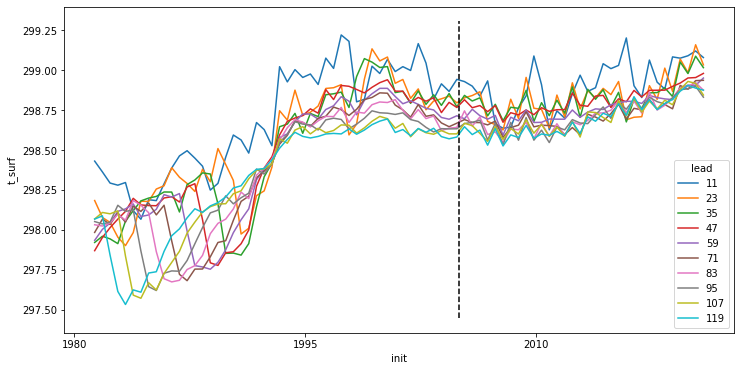

In [229]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))
test.plot.line(x="init", add_legend=True)
ylim = plt.gca().get_ylim()
plt.plot(
    [cftime.DatetimeJulian(2005, 1, 1), cftime.DatetimeJulian(2005, 1, 1)],
    ylim,
    color="k",
    linestyle="--",
)

In [190]:
hindcast = HindcastEnsemble(cafe_hcst.rename({"time": "my_time"}))
# hindcast = hindcast.add_uninitialized(cafe_hist_ts.chunk({"time": -1, "lat": 1}))
hindcast = hindcast.add_observations(jra55)

<AxesSubplot:xlabel='validity time', ylabel='t_surf'>

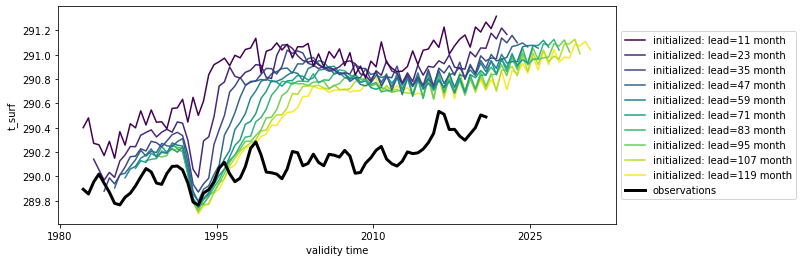

In [196]:
hindcast.sel(lat=slice(-60, 60)).mean(["lat", "lon"]).plot()

In [183]:
hindcast.remove_bias(alignment='same_verifs', how='additive_mean')

NotImplementedError: Can not use auto rechunking with object dtype. We are unable to estimate the size in bytes of object data

In [177]:
rmse = hindcast.verify(
    metric="rmse", comparison="e2o", alignment="same_verifs", dim=["init"]
)

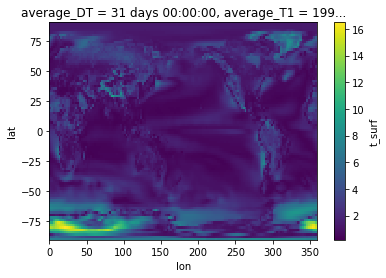

In [181]:
rmse["t_surf"].sel(lead=119).plot()

In [162]:
hindcast.remove_bias(
    how="additive_mean",
    alignment="same_verifs",
    train_test_split="unfair",
)  # .mean(['lat','lon']).plot()

Python 3.9.4 | packaged by conda-forge | (default, May 10 2021, 22:13:33) 
Type 'copyright', 'credits' or 'license' for more information
IPython 7.24.0 -- An enhanced Interactive Python. Type '?' for help.



In [1]:  verif_dates


Out[1]: 
{11: CFTimeIndex([1991-04-01 00:00:00, 1991-10-01 00:00:00, 1992-04-01 00:00:00,
              1992-10-01 00:00:00, 1993-04-01 00:00:00, 1993-10-01 00:00:00,
              1994-04-01 00:00:00, 1994-10-01 00:00:00, 1995-04-01 00:00:00,
              1995-10-01 00:00:00, 1996-04-01 00:00:00, 1996-10-01 00:00:00,
              1997-04-01 00:00:00, 1997-10-01 00:00:00, 1998-04-01 00:00:00,
              1998-10-01 00:00:00, 1999-04-01 00:00:00, 1999-10-01 00:00:00,
              2000-04-01 00:00:00, 2000-10-01 00:00:00, 2001-04-01 00:00:00,
              2001-10-01 00:00:00, 2002-04-01 00:00:00, 2002-10-01 00:00:00,
              2003-04-01 00:00:00, 2003-10-01 00:00:00, 2004-04-01 00:00:00,
              2004-10-01 00:00:00, 2005-04-01 00:00:00, 2005-10-01 00:00:00,
              2006-04-01 00:00:00, 2006-10-01 00:00:00, 2007-04-01 00:00:00,
              2007-10-01 00:00:00, 2008-04-01 00:00:00, 2008-10-01 00:00:00,
              2009-04-01 00:00:00, 2009-10-01 00:00:00, 2010-04

In [2]:  exit()


NotImplementedError: Can not use auto rechunking with object dtype. We are unable to estimate the size in bytes of object data

# Why does this fail?

`climpred.utils.add_time_from_init_lead` does not work: issue opened here: https://github.com/pangeo-data/climpred/issues/698

In [29]:
import climpred
import numpy as np
import xarray as xr

# Hindcasts initialised every 6 months with yearly lead
init = xr.cftime_range(start="2000-01-01", end="2002-01-01", freq="MS")
lead = range(1, 4)
data = np.random.random((len(init), len(lead)))
hind = xr.DataArray(data, coords=[init, lead], dims=["init", "lead"], name="var")
hind["lead"].attrs["units"] = "seasons"

# Add "valid_time" coordinate using `climpred.utils.add_time_from_init_lead()`
hind = climpred.utils.add_time_from_init_lead(hind)
print(hind["valid_time"])

<xarray.DataArray 'valid_time' (lead: 3, init: 25)>
array([[cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 7, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 7, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 7, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 10, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 10, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 10, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2001, 1, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2001, 1, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2001, 1, 1, 0, 0, 0, 0, has_year_zero=False

Also, the "same_verifs" alignment generates a list of times from `verif` that are present in `forecast` at any init but all leads. This list will always be empty when the init frequency is lower than the lead frequency. Is there scope to extend "same_verifs" to instead deal appropriately with such cases? I'll give a concrete example of what I mean below.

Consider the following hindcasts:

In [2]:
import cftime
import climpred
import numpy as np
import xarray as xr

# Hindcasts initialised every year with monthly lead
init = xr.cftime_range(start="2000-01-01", end="2002-01-01", freq="AS")
lead = range(0, 24)
data = np.random.random((len(init), len(lead)))
hind = xr.DataArray(data, coords=[init, lead], dims=["init", "lead"], name="var")
hind["lead"].attrs["units"] = "months"
hind = climpred.utils.add_time_from_init_lead(hind)

I currently can't use "same_verifs" with this data because there are no common times available at all leads.

But, users may still want to align based on a common verification period. In this example, "valid_time"s [2001-01-01 and 2002-01-01] are available at all possible leads for which they can occur (leads 0 and 12 months). Similarly, [2001-02-01 and 2002-02-01] are available at leads 1 and 13 months, [2001-03-01 and 2002-03-01] are available at leads 2 and 14 months... [2001-12-01 and 2002-12-01] are available at leads 11 and 23 months.

That is, by performing verification over the period 2001-01-01 - 2002-12-01 one includes:
- the same dates at each lead, where possible
- the same number of samples at each lead

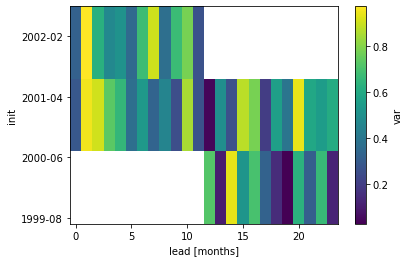

In [3]:
period = [cftime.DatetimeGregorian(2001, 1, 1), cftime.DatetimeGregorian(2002, 12, 1)]

hind.where(
    np.logical_and(hind["valid_time"] >= period[0], hind["valid_time"] <= period[1])
).plot()

How do folks feel about trying to restructure `cftime.utils._same_verifs_alignment()` use the above alignment dates in the above example? We would obviously do this such that the current behaviour is preserved for datasets that have common verification times across all leads.

In [96]:
hind.isel(lead=-1).valid_time

<xarray.DataArray 'valid_time' (init: 5)>
array([cftime.DatetimeGregorian(2001, 6, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2001, 9, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2001, 12, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2002, 3, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2002, 6, 1, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * init        (init) object 2000-01-01 00:00:00 ... 2001-01-01 00:00:00
    lead        int64 17
    valid_time  (init) object 2001-06-01 00:00:00 ... 2002-06-01 00:00:00
Attributes:
    long_name:      validity time
    standard_name:  time
    description:    time for which the forecast is valid
    calculate:      init + lead

In [22]:
N_LEAD = 12
N_INIT = 4
N_MEMBER = 1
INIT_FREQ = "MS"
LEAD_UNITS = "seasons"

init = xr.cftime_range(start="2000-01-01", periods=N_INIT, freq=INIT_FREQ)
lead = range(N_LEAD)
member = range(N_MEMBER)
data = np.random.random(
    (
        len(init),
        len(lead),
        len(member),
    )
)
hind = xr.DataArray(
    data, coords=[init, lead, member], dims=["init", "lead", "member"], name="var"
)
hind["lead"].attrs["units"] = LEAD_UNITS

In [23]:
time = xr.cftime_range(start="2000-01-01", end="2020-01-01", freq="MS")
data = np.random.random((len(time),))
obs = xr.DataArray(data, coords=[time], dims=["time"], name="var")

In [24]:
hindcast = HindcastEnsemble(hind)
hindcast = hindcast.add_observations(obs)

In [25]:
hind

<xarray.DataArray 'var' (init: 4, lead: 12, member: 1)>
array([[[0.54144663],
        [0.66904845],
        [0.91749193],
        [0.63214365],
        [0.68733282],
        [0.11864336],
        [0.97551382],
        [0.12495922],
        [0.85152013],
        [0.99807666],
        [0.41124309],
        [0.39181909]],

       [[0.71980423],
        [0.74272177],
        [0.97659812],
        [0.60581274],
        [0.07494726],
        [0.73566343],
        [0.57162996],
...
        [0.74410831],
        [0.94208463],
        [0.4510831 ],
        [0.5425994 ],
        [0.28562122],
        [0.08264346],
        [0.93769972]],

       [[0.1748957 ],
        [0.70713425],
        [0.42543921],
        [0.90540383],
        [0.41789119],
        [0.46219138],
        [0.7043307 ],
        [0.16657152],
        [0.09681265],
        [0.03574377],
        [0.12381093],
        [0.59827523]]])
Coordinates:
  * init     (init) object 2000-01-01 00:00:00 ... 2000-04-01 00:00:00
  * lead     (lead) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * member   (member) int64 0

In [26]:
obs

<xarray.DataArray 'var' (time: 241)>
array([0.37752062, 0.95460547, 0.38204115, 0.31314914, 0.92194664,
       0.64657256, 0.53725517, 0.12291584, 0.96916604, 0.36277988,
       0.61851365, 0.7537338 , 0.56669241, 0.44768371, 0.82557689,
       0.47140051, 0.52549738, 0.58217009, 0.49263769, 0.11562466,
       0.97957095, 0.63297069, 0.39164867, 0.79359721, 0.56204885,
       0.02061311, 0.35239929, 0.26737541, 0.16127904, 0.64155635,
       0.52762899, 0.94933615, 0.19137846, 0.86137227, 0.73669599,
       0.06455336, 0.23312301, 0.86072369, 0.94932701, 0.25208019,
       0.09224607, 0.5665481 , 0.85122954, 0.59094464, 0.70553157,
       0.0122739 , 0.63861019, 0.26284126, 0.39655066, 0.35538334,
       0.81865549, 0.26227138, 0.62114251, 0.15537506, 0.67468754,
       0.5271349 , 0.41848248, 0.58701655, 0.51405526, 0.3680225 ,
       0.85240982, 0.74930019, 0.01787711, 0.58237501, 0.05131743,
       0.10333228, 0.9622511 , 0.07627341, 0.00203591, 0.61876593,
       0.7230973 , 0.82143748, 0.16662854, 0.34639961, 0.46084646,
       0.46176265, 0.08014773, 0.28659329, 0.12634483, 0.90097068,
       0.14448222, 0.26285697, 0.03592824, 0.68772431, 0.61957715,
       0.15004523, 0.63420339, 0.30987887, 0.60421987, 0.46788115,
       0.83727778, 0.91595819, 0.85537811, 0.21140361, 0.83989837,
       0.63460233, 0.71571159, 0.42009682, 0.19144974, 0.30475115,
...
       0.44966719, 0.53704206, 0.87490688, 0.97097114, 0.83558484,
       0.38331397, 0.50157837, 0.81618363, 0.916146  , 0.07994578,
       0.61517016, 0.47226786, 0.94722848, 0.05678799, 0.28255389,
       0.88536065, 0.00251698, 0.11847429, 0.49555373, 0.11123324,
       0.48499846, 0.95841982, 0.96572454, 0.872982  , 0.18045605,
       0.77143465, 0.23427918, 0.48834729, 0.45275585, 0.84351744,
       0.40706963, 0.90959248, 0.37971044, 0.2493755 , 0.11038839,
       0.59805037, 0.02286502, 0.08715644, 0.56589771, 0.54073473,
       0.3733233 , 0.48170482, 0.87525937, 0.50880686, 0.76794057,
       0.26034554, 0.52338374, 0.92554979, 0.221161  , 0.19701517,
       0.5890258 , 0.2739623 , 0.99717928, 0.36380137, 0.35615313,
       0.63465954, 0.19762139, 0.53130057, 0.89880828, 0.26225154,
       0.20841019, 0.24020364, 0.16007738, 0.54479091, 0.39404393,
       0.36206807, 0.51573993, 0.98411141, 0.33696675, 0.67707841,
       0.9853252 , 0.84540128, 0.8504817 , 0.68738735, 0.28957642,
       0.66218842, 0.04724086, 0.35107197, 0.05063898, 0.34404718,
       0.0302472 , 0.18315762, 0.50945319, 0.2337988 , 0.22403024,
       0.51737465, 0.65027949, 0.16595005, 0.6665585 , 0.72884227,
       0.6318273 , 0.633769  , 0.83807691, 0.64485601, 0.30859164,
       0.30765394])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2020-01-01 00:00:00

In [27]:
result = hindcast.verify(
    metric="rmse",
    comparison="e2o",
    dim="init",
    alignment="same_verif",
)

Python 3.9.4 | packaged by conda-forge | (default, May 10 2021, 22:13:33) 
Type 'copyright', 'credits' or 'license' for more information
IPython 7.24.0 -- An enhanced Interactive Python. Type '?' for help.



In [1]:  init_lead_matrix


Out[1]: 
<xarray.DataArray (lead: 12, time: 4)>
array([[cftime.DatetimeGregorian(2000, 1, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False)],
       [cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 4, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 7, 1, 0, 0, 0, 0, has_year_zero=False)],
       [cftime.DatetimeGregorian(2000, 7, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 7, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 7, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2000, 10, 1, 0, 0, 0, 0, has_year_zero=False)],


In [2]:  exit()


CoordinateError: A common set of verification dates cannot be found for the initializations and verification data supplied. Change `alignment` to 'same_inits' or 'maximize'.

In [114]:
result["var"].plot()

<Figure size 432x288 with 1 Axes>


In [192]:
acc = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='same_init')

CPU times: user 1.51 s, sys: 91.4 ms, total: 1.6 s
Wall time: 5.93 s


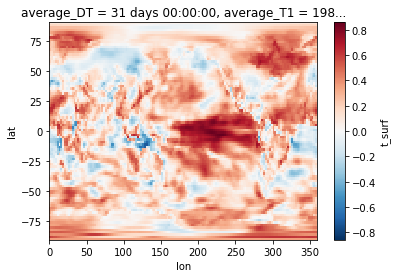

In [200]:
%%time
acc['t_surf'].isel(lead=0).plot()

In [196]:
cafe_hcst

<xarray.DataArray 't_surf' (init: 80, lead: 120, member: 96, lat: 90, lon: 144)>
dask.array<concatenate, shape=(80, 120, 96, 90, 144), dtype=float32, chunksize=(1, 24, 96, 90, 144), chunktype=numpy.ndarray>
Coordinates:
    area        (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>
    average_DT  (lead) timedelta64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
    average_T1  (lead) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
    average_T2  (lead) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
  * member      (member) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * lat         (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lead        (lead) int64 0 1 2 3 4 5 6 7 ... 112 113 114 115 116 117 118 119
    zsurf       (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>
  * init        (init) object 1981-05-16 12:00:00 ... 2020-11-16 00:00:00
Attributes:
    cell_methods:   time: mean
    long_name:      surface temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          deg_k
    valid_range:    [100.0, 400.0]